<img src="https://1onjea25cyhx3uvxgs4vu325-wpengine.netdna-ssl.com/wp-content/themes/udacity_wp_1_8/images/Udacity_Logo_SVG_200x35.svg" style=" margin: 30px; height: 30px">



# Pneumonia Detection from Chest X-Rays

<img src="https://miro.medium.com/max/1400/1*rZ8wn3AO4CtzW_DGSQJjPg.png" style="height: 250px; width: 1000px">

### AI for Healthcare Nanodegree Program
**Project 1**

**Name**: Raghad Alharbi

**LinkedIn**: [Raghad-Alharbi](https://www.linkedin.com/in/raghad-alharbi/)

---
## Build and Train Model

## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from random import sample
from itertools import chain
from matplotlib.colors import ListedColormap
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Pallets used for visualizations
color= "Spectral"
color_hist = 'teal'

BOLD = "\033[1m"
END = "\033[0m"

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
df['path'] = df['Image Index'].map(all_image_paths.get)
df.drop('Unnamed: 11', axis=1, inplace=True)
df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
5423,00001441_000.png,No Finding,0,1441,59,M,PA,2021,2021,0.194311,0.194311,/data/images_002/images/00001441_000.png
80370,00019750_026.png,No Finding,26,19750,57,M,PA,2992,2991,0.143000,0.143000,/data/images_009/images/00019750_026.png
56458,00014036_002.png,No Finding,2,14036,36,M,PA,2746,2991,0.143000,0.143000,/data/images_007/images/00014036_002.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
35241,00009302_022.png,Infiltration,22,9302,40,F,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,0
93011,00023217_000.png,No Finding,0,23217,66,M,PA,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
19380,00005138_006.png,Nodule,6,5138,54,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,1,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
df['pneumonia_class']= np.where(df ['Pneumonia']==1, 'Pneumonia', 'No_Pneumonia')

In [5]:
print('Minimum age = ',df['Patient Age'].min())
print('Maximum age = ',df['Patient Age'].max())
print('Number of patients with age more than 100 =',df['Patient Age'][df['Patient Age']>100].value_counts().sum())
print('Removing outliers (patients with age more than 100) ...')
df = df [df['Patient Age']<100]

Minimum age =  1
Maximum age =  414
Number of patients with age more than 100 = 16
Removing outliers (patients with age more than 100) ...


## Create your training and testing data:

In [6]:
def create_splits(dataframe, test_size, target_column):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(dataframe, 
                                   test_size = test_size, 
                                   stratify = dataframe[target_column])
    
    print(BOLD+'Training dataset:'+END )
    print('Prevelance of Pneumonia:', len(train_data[train_data[target_column]=='Pneumonia'])/len(train_data))
    
    print('Number of',BOLD,'pnuemonia',END, 'cases in the train data:', len(train_data[train_data[target_column]=='Pneumonia']))
    print('Number of',BOLD,'non-pneumonia',END, 'cases in the train data: ', len(train_data[train_data[target_column]=='No_Pneumonia'])) ;print()
    
    print(BOLD+'Rebalancing train dataset..', END)
    # choosing only a part of the not Pneumothorax cases in the train to make the
    is_true_target = train_data[train_data[target_column]=='Pneumonia'].index.tolist()
    not_true_target = train_data[train_data[target_column]=='No_Pneumonia'].index.tolist()

    not_p_sample = sample(not_true_target,len(is_true_target))
    train_data = train_data.loc[is_true_target + not_p_sample]
                                
    print('Prevelance of Pneumonia:', len(train_data[train_data[target_column]=='Pneumonia'])/len(train_data))
    
    print('Number of',BOLD,'pnuemonia',END, 'cases in the train data:', len(train_data[train_data['pneumonia_class']=='Pneumonia']))
    print('Number of',BOLD,'non-pneumonia',END, 'cases in the train data: ', len(train_data[train_data['pneumonia_class']=='No_Pneumonia'])) ;print()
    
    print(BOLD+'Validation dataset:'+END )
    print('Prevelance of Pneumonia :', len(val_data[val_data[target_column]=='Pneumonia'])/len(val_data))
    
    print('Number of',BOLD,'pnuemonia',END, 'cases in the valid data:', len(val_data[val_data[target_column]=='Pneumonia']))
    print('Number of',BOLD,'non-pneumonia',END, 'cases in the valid data: ', len(val_data[val_data[target_column]=='No_Pneumonia'])) ;print()
    
    print(BOLD+'Rebalancing validation dataset..', END)
    # choosing only a part of the not Pneumothorax cases in the valid to make the
    is_true_val = val_data[val_data[target_column]=='Pneumonia'].index.tolist()
    not_true_val = val_data[val_data[target_column]=='No_Pneumonia'].index.tolist()

    not_p_val_sample = sample(not_true_val,5*len(is_true_val))
    val_data = val_data.loc[is_true_val + not_p_val_sample]
                                
    print('Prevelance of Pneumonia:', len(val_data[val_data[target_column]=='Pneumonia'])/len(val_data))
    
    print('Number of',BOLD,'pnuemonia',END, 'cases in the valid data:', len(val_data[val_data['pneumonia_class']=='Pneumonia']))
    print('Number of',BOLD,'non-pneumonia',END, 'cases in the valid data: ', len(val_data[val_data['pneumonia_class']=='No_Pneumonia'])) 
    
    return train_data, val_data

In [7]:
train_df, val_df = create_splits(df, 0.2, 'pneumonia_class')

Training dataset:
Prevelance of Pneumonia: 0.012756040721206917
Number of  pnuemonia  cases in the train data: 1144
Number of  non-pneumonia  cases in the train data:  88539

Rebalancing train dataset.. 
Prevelance of Pneumonia: 0.5
Number of  pnuemonia  cases in the train data: 1144
Number of  non-pneumonia  cases in the train data:  1144

Validation dataset:
Prevelance of Pneumonia : 0.01275589848802462
Number of  pnuemonia  cases in the valid data: 286
Number of  non-pneumonia  cases in the valid data:  22135

Rebalancing validation dataset.. 
Prevelance of Pneumonia: 0.16666666666666666
Number of  pnuemonia  cases in the valid data: 286
Number of  non-pneumonia  cases in the valid data:  1430


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation():
    
    ## implement a ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True , 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range =0.1 , 
                              rotation_range =10 , 
                              shear_range = 0.1,
                              zoom_range=0.1,   
                        )
    
    return idg


def make_train_gen(train_df,img_size, batch_size ):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Use the flow_from_dataframe library
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = batch_size,
                                         shuffle=True
                                         )
    return train_gen


def make_val_gen(val_df,img_size, batch_size ):
    
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = img_size, 
                                             batch_size = batch_size) 

    return val_gen

In [81]:
IMAGE_SIZE = 224
img_size = (IMAGE_SIZE, IMAGE_SIZE)
train_batch_size = 128 # 64
val_batch_size = 1000
print(BOLD+ 'Train data:',END)
train_gen = make_train_gen(train_df, img_size, train_batch_size)
print(BOLD+ 'Validation data:',END)
val_gen = make_val_gen(val_df, img_size, val_batch_size)

Train data: 
Found 2288 validated image filenames belonging to 2 classes.
Validation data: 
Found 1716 validated image filenames belonging to 2 classes.


In [82]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_X, val_Y = val_gen.next()

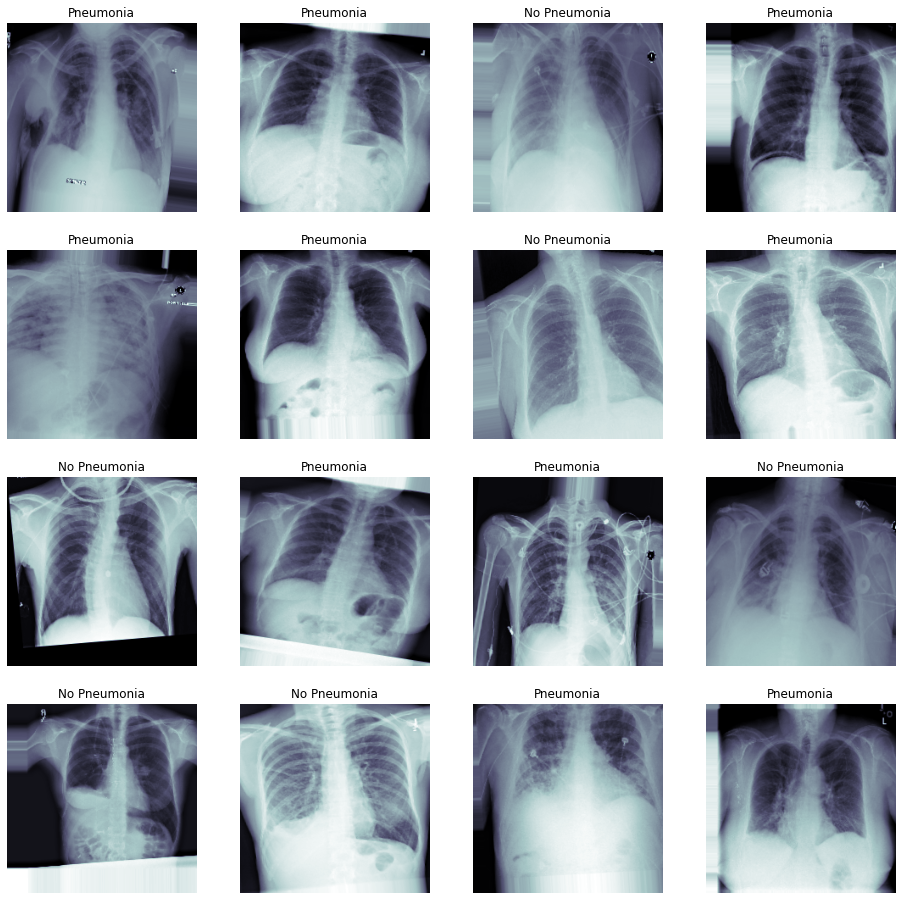

In [46]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

we are only augmenting the training data to increase the number of the training dataset, but for validation data, we are not augmenting because we want the validation data to resemble the real-world data as closely as possible.

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [83]:
def load_pretrained_model(lay_of_interest, IMAGE_SIZE):
    
    model = VGG16(include_top=False, weights='imagenet',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    #for layer in vgg_model.layers[15:]:
    #    layer.trainable = True    
    
    return vgg_model

In [84]:
def build_my_model(IMAGE_SIZE):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model('block5_pool', IMAGE_SIZE)
    
    my_model = Sequential()
    my_model.add(vgg_model)
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.3))
    my_model.add(Dense(1024, activation='relu'))
    
    my_model.add(Dropout(0.3))
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(0.3))
    my_model.add(Dense(256, activation='relu'))

    my_model.add(Dropout(0.3))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [85]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

# Build the model,
model = build_my_model(IMAGE_SIZE)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_8 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)              

In [86]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=15)

callbacks_list = [checkpoint, early]

### Start training! 

In [87]:
## train your model

# Todo
history = model.fit_generator(train_gen, 
                          validation_data = (val_X, val_Y), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
18/18 [==============================] - 77s 4s/step - loss: 0.7417 - binary_accuracy: 0.5153 - val_loss: 0.6406 - val_binary_accuracy: 0.6840

Epoch 00001: val_loss improved from inf to 0.64061, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
18/18 [==============================] - 53s 3s/step - loss: 0.7127 - binary_accuracy: 0.5437 - val_loss: 0.6513 - val_binary_accuracy: 0.6690

Epoch 00002: val_loss did not improve from 0.64061
Epoch 3/30
18/18 [==============================] - 61s 3s/step - loss: 0.6937 - binary_accuracy: 0.5428 - val_loss: 0.6249 - val_binary_accuracy: 0.6870

Epoch 00003: val_loss improved from 0.64061 to 0.62495, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
18/18 [==============================] - 61s 3s/step - loss: 0.6870 - binary_accuracy: 0.5564 - val_loss: 0.6610 - val_binary_accuracy: 0.6390

Epoch 00004: val_loss did not improve from 0.62495
Epoch 5/30
18/18 [==============================] - 60s 3s/step - loss: 0.6725

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [88]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(val_X, batch_size = 100, verbose = True)

1000/1000 [==============================] - 10s 10ms/step


In [89]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, ax = plt.subplots(1,1, figsize = (6, 6))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', roc_auc), linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax.legend(loc="lower right", prop={'size': 14})
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):

    ## YOUR CODE HERE
    ## Note you can utilizat precision_recall_curve imported above
    fig, ax = plt.subplots(1,1, figsize = (6, 6))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    pr_avrage = average_precision_score(t_y,p_y)
    ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia',pr_avrage ))
    ax.plot([0, 1], [1, 0], 'k--', linewidth=2)
    ax.legend(loc="lower left", prop={'size': 14})
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

    
def plot_auc_pr(t_y, p_y):  
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(13,6))
    fig.suptitle("Model Performance Visualization", fontsize=16)
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', roc_auc), linewidth=2)
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax1.legend(loc="lower right", prop={'size': 14})
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title("AUC ROC CURVE", fontsize=16)
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    pr_avrage = average_precision_score(t_y,p_y)
    ax2.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia',pr_avrage ))
    ax2.plot([0, 1], [1, 0], 'k--', linewidth=2)
    ax2.legend(loc="lower left", prop={'size': 14})
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title("Precision Recall Curve", fontsize=16)
    
def calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4) 

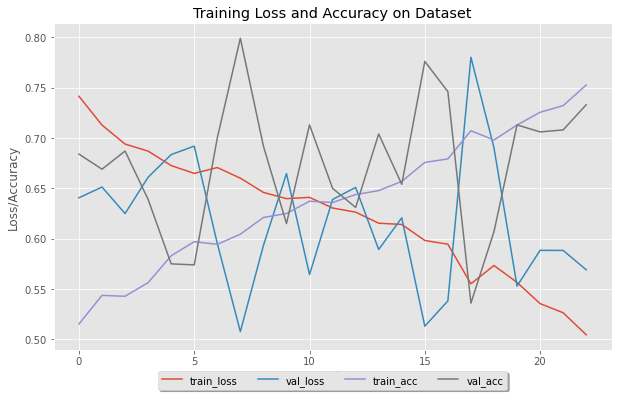

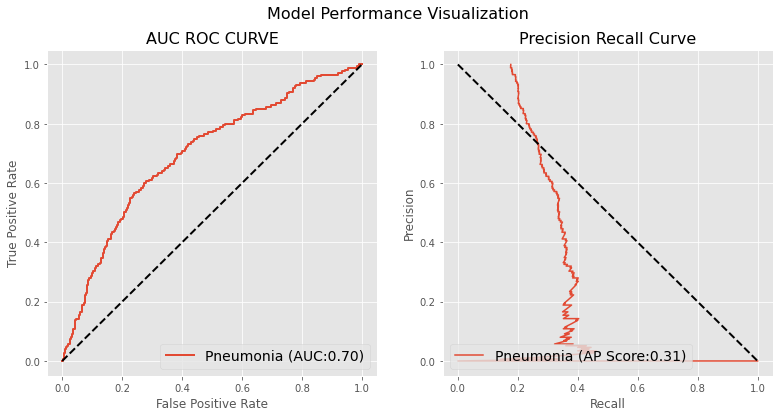

In [90]:
## plot figures
plot_history(history)
plot_auc_pr(val_Y.astype(int), pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [91]:
def plot_f1_threshold(t_y,p_y):
        
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1_scores = []

    for i in thresholds:
        f1 = f1_score(t_y, binarize(p_y,i))
        f1_scores.append(f1)

    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    ax.plot(thresholds, f1_scores, label = 'F1 Score')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')

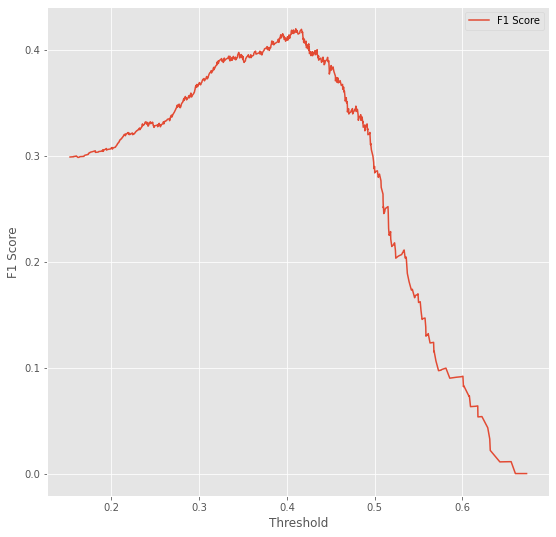

In [92]:
plot_f1_threshold (val_Y.astype(int), pred_Y)

Setting the threshold to maximize the F1 score..
Threshold: 0.41005385

Confusion Matrix: 
                 Predicted Negative  Predicted Positive
Actual Negative                 629                 196
Actual Positive                  77                  98

Classification Report:  
              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       825
         1.0       0.33      0.56      0.42       175

    accuracy                           0.73      1000
   macro avg       0.61      0.66      0.62      1000
weighted avg       0.79      0.73      0.75      1000


Accuracy = 0.727
Precision = 0.3333333333333333
Recall    = 0.56
F1 Score  = 0.41791044776119407
Sensitivity = 0.56
Specificity = 0.7624242424242424


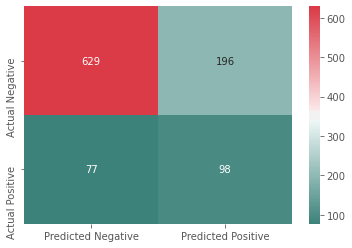

In [97]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
# finding best threshold that gives us the max F1
max_f1 = 0
f1 = 0
best_threshold = None
for t in np.arange(0.0,1,0.01):        
    y_pred_class = pred_Y > t
    f1 = f1_score(val_Y, y_pred_class)
    if max_f1 < f1:
        max_f1 = f1
        best_threshold = t
        
MY_THRESHOLD = best_threshold
idx = (np.abs(thresholds - MY_THRESHOLD)).argmin() 
print('Setting the threshold to maximize the F1 score..')
print('Threshold: '+ str(thresholds[idx]));print()
cm_df = pd.DataFrame(confusion_matrix(val_Y, np.where (pred_Y> round(thresholds[idx], 3), 1,0)), 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
print(BOLD+'Confusion Matrix: '+END)
print(cm_df);print()
fig, ax = plt.subplots(figsize = (6,4))
sns.heatmap(cm_df, annot=True, fmt='.3g', cmap = sns.diverging_palette(180, 10, as_cmap = True))
TP = cm_df.iloc[1][1]
TN = cm_df.iloc[0][0]
FP = cm_df.iloc[0][1]
FN = cm_df.iloc[1][0]


print('Classification Report:  ')
print(classification_report(val_Y, np.where (pred_Y> round(thresholds[idx], 3), 1,0)));print()

print('Accuracy = '+ str( accuracy_score(val_Y, np.where (pred_Y> round(thresholds[idx], 3), 1,0))))
print('Precision = '+ str(precision[idx]))
print('Recall    = '+ str(recall[idx]))
print('F1 Score  = ' + str(calc_f1(precision[idx],recall[idx])))

# calculate the sensitivity
sensitivity = (TP / float(TP + FN))
print ('Sensitivity =', sensitivity)
# calculate the specificity
specificity = (TN / float(TN + FP))
print ('Specificity =', specificity)


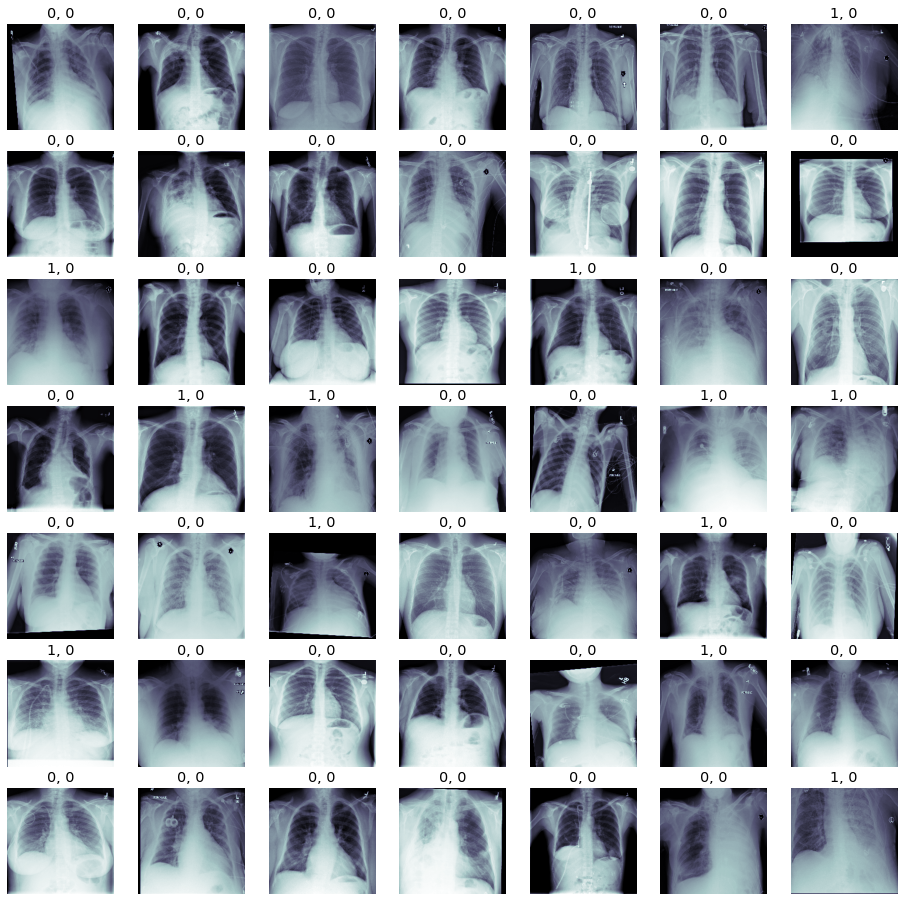

In [95]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(7, 7, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_X[0:60], val_Y[0:60], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > MY_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > MY_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [98]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)